# Набор инструментов


Тренировка нейросетей может занимать значительное время, так что есть несколько важных вещей, которые надо не забыть:

- сохранять промежуточные/лучшие веса (делать чекпоинты)
- писать логи в адекватном формате (так, чтобы они не терялись при перезапуске тетрадки)


**План тетрадки**
1. Логгирование и tensorboard
2. Сохранение-восстановление весов
3. Dataset API в pytorch
4. Выбор LR
5. Практика
6. Затухающие градиенты и Residual-блоки


Есть множество вариантов хранения логов и артефактов (весов) обучения. Прежде чем выбрать какое-то коробочное решение имеет смысл попробовать собрать несколько своих велосипедов.


## Логгирование

В предыдущих тетрадках мы хранили тренировочные логи в словарях со списками. Это неплохой вариант, его можно сериализовать в файлы и рисовать в отдельном коде. Однако эти логи бесполезны без знания _схемы_.

Довольно распространенным вариантом является формат tensorboard: это бинарный формат (не текстовые, как json) с готовым просмотрщиком.




[Tensorboard](https://www.tensorflow.org/tensorboard) -- это pip-installable web-приложение.

```
tensorboard --logdirs=./some-folder/with/events-files
# зайти на http://localhost:6006
```
<img src="./img/tb.png"/>

При желании, можно написать python-код для парсинга логов и делать что-то с ними руками.

Чтобы писать логи в pytorch есть класс `torch.utils.tensorboard.SummaryWriter`

In [1]:
import numpy as np
from torch.utils.tensorboard import SummaryWriter


writer = SummaryWriter("./check-this/")

fake_loss = 1 / np.arange(1, 100)
for global_step, point in enumerate(fake_loss):
    writer.add_scalar("lossy", point, global_step=global_step)
writer.close()

In [2]:
! ls check-this

# поставьте tensorboard
# запустите его в папке с логами

"ls" не является внутренней или внешней
командой, исполняемой программой или пакетным файлом.


TB умеет рисовать множество графиков, для этого достаточно писать их в разные папки, лежащие в `--logdir`.

Хорошая практика: для каждого запуска обучения заводить отдельную папку с логами, записывать туда словарь с гиперпараметрами и логи.

## Состояния модели и оптимизатора

Нам часто бывает необходимо сохранить/загрузить веса модели. Расхожее название для этого `checkpoint`.
В DL термином `checkpointing` называют так же метод бекпропа, позволяющий экономить память ценой дополнительных вычислений (https://pytorch.org/docs/stable/checkpoint.html#torch-utils-checkpoint).

У торчевых моделей и оптимизаторов есть методы для получения и загрузки состояний:
- `.state_dict()` возвращает словарь (или почти словарь) с весами
- `.load_state_dict()` загружает веса из словаря в модельку



Для сохранения/загрузки словарей с тензорами в файлы есть простые функции `torch.save(some_dict, path)`, `torch.load(path)`. Сравните с использованием `pickle` или `json`!


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim


some_model = nn.Sequential(nn.Linear(10, 10))
print(some_model.state_dict())

opt = optim.Adam(some_model.parameters())
print(opt.state_dict())


torch.save({"model_stuff": some_model.state_dict(), "opt_stuff": opt.state_dict()}, "./that.is.it")

OrderedDict([('0.weight', tensor([[ 0.0537,  0.1499, -0.2192, -0.0857,  0.2263,  0.1745,  0.0855, -0.1304,
          0.0881, -0.0256],
        [-0.0998, -0.0159, -0.2969,  0.1274,  0.2709, -0.1286, -0.2792, -0.0756,
          0.0351,  0.2648],
        [-0.0035, -0.1252,  0.2096, -0.0209,  0.2516, -0.0838,  0.2050,  0.1773,
          0.0419, -0.3104],
        [-0.0958,  0.3035, -0.2445, -0.2444,  0.2839, -0.2623, -0.1304, -0.0537,
          0.1547,  0.0237],
        [-0.2207,  0.1917,  0.1251,  0.0941,  0.1554, -0.0080, -0.2743,  0.1702,
         -0.2803, -0.0285],
        [ 0.2883, -0.2187,  0.2600, -0.2831, -0.2846, -0.1991, -0.1402,  0.0964,
          0.0343,  0.1376],
        [ 0.1308,  0.1745,  0.1613,  0.0055,  0.2981,  0.1825,  0.0548, -0.2786,
          0.1715,  0.0674],
        [-0.2071, -0.1833,  0.0307,  0.1321, -0.1525,  0.2408,  0.1178, -0.1484,
         -0.0683,  0.1800],
        [ 0.0031,  0.1781, -0.0412,  0.1125, -0.0884,  0.1154,  0.2630, -0.0961,
          0.1325,  0.

In [4]:
torch.load("./that.is.it")

{'model_stuff': OrderedDict([('0.weight',
               tensor([[ 0.0537,  0.1499, -0.2192, -0.0857,  0.2263,  0.1745,  0.0855, -0.1304,
                         0.0881, -0.0256],
                       [-0.0998, -0.0159, -0.2969,  0.1274,  0.2709, -0.1286, -0.2792, -0.0756,
                         0.0351,  0.2648],
                       [-0.0035, -0.1252,  0.2096, -0.0209,  0.2516, -0.0838,  0.2050,  0.1773,
                         0.0419, -0.3104],
                       [-0.0958,  0.3035, -0.2445, -0.2444,  0.2839, -0.2623, -0.1304, -0.0537,
                         0.1547,  0.0237],
                       [-0.2207,  0.1917,  0.1251,  0.0941,  0.1554, -0.0080, -0.2743,  0.1702,
                        -0.2803, -0.0285],
                       [ 0.2883, -0.2187,  0.2600, -0.2831, -0.2846, -0.1991, -0.1402,  0.0964,
                         0.0343,  0.1376],
                       [ 0.1308,  0.1745,  0.1613,  0.0055,  0.2981,  0.1825,  0.0548, -0.2786,
                         0.1

## Dataset API

Подготовка данных легко может стать бутылочным горлышком, когда на подготовку очередного батча уходит больше времени, чем на forward+backward проходы по сети.
Проблема усложняется особенностями python: чтобы использовать несколько ядер CPU для подготовки данных надо постараться.

В Pytorch работа с данными строится на двух классах из [troch.utils.data](https://pytorch.org/docs/stable/data.html): `Dataset` и `DataLoader`:

- `Dataset` отвечает за подготовку одного примера
- `DataLoader` отвечает за выбор примеров, склейку их в один батч и распараллеливание на CPU, поддерживает итерирование.


Для решения задачи обычно пишут кастомные Dataset-классы, для этого нужно написать всего две функции:
- `.__len__(self)` возвращает количество примеров в датасете;
- `.__getitem__(self, item)` возвращает item-ный по счету пример из датасета.

Задачи DataLoader достаточно сложно аккуратно реализовать и лучше использовать готовый. Он довольно гибкий, все основные моменты кастомизируются заданием функций:
```
torch.utils.data.DataLoader(
    dataset,            # собственно экземпляр класса Dataset, из которого надо доставать примеры
    batch_size=1,       # количество примеров в батче
    drop_last=False,    # нужно ли при итерировании выбрасывать неполные батчи? (такое бывает, если число примеров не делится нацело на batch_size
    shuffle=False,      # перемешивать ли примеры
    sampler=None,       # чтобы перемешивать примеры кастомно
    batch_sampler=None, # чтобы использовать кастомный отбор примеров в батч
    num_workers=0,      # на сколько процессов запараллелить подготовку данных
    collate_fn=None,    # функция, которая будет склеивать примеры в батчи
    # остальные аргументы более технические, сейчас можно не рассматривать
    pin_memory=False,   
    timeout=0, 
    worker_init_fn=None, 
    multiprocessing_context=None, 
    generator=None)
```

Напишите два датасета для работы с FashionMnist: один готовит данные как вектора, другой как картинки


**NB: FashionMNIST возвращает картинки в формате PIL.Image.Image, чтобы сделать из него понятный np.array, просто вызовите np.array(PIL_IMAGE)**

In [5]:
import numpy as np
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST


class VectorSet:
    def __init__(self, train=True):
        self.data = FashionMNIST("./tmp", train=train, download=True)
    
    def __len__(self):
        return self.data.__len__()
    
    def __getitem__(self, item):
        # сделайте вектор с float32 числами
        entry = self.data.__getitem__(item)
        return dict(
            sample=np.array(entry[0], dtype='float32').ravel(),
            label=entry[1],
        )

vs = VectorSet()
print(vs[0])
        
class ImageSet:
    def __init__(self, train=True):
        self.data = FashionMNIST("./tmp", train=train, download=True)
    
    def __len__(self):
        return self.data.__len__()
    
    def __getitem__(self, item):
        # сделайте одноканальную картинку [1, 28, 28] с float32
        entry = self.data.__getitem__(item)
        return dict(
            sample=np.expand_dims(np.array(entry[0], dtype='float32'), axis=0),
            label=entry[1],
        )
    
ms = ImageSet()
print(ms[0])

{'sample': array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
        13.,  73.,   0.,   0.,   1.,   4.,   0.,   0.,   0.,   0.,   1.,
         1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   3.,   0.,  36., 136., 127.,  62.,  54.,   0.,
         0.,   0.,   1.,   3.,   4.,   0.,   0.,   3.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0

In [6]:
# проверьте итерирование, именно его мы используем в train-loop'е
vl = DataLoader(vs, batch_size=4)
for batch in vl:
    for k, v in batch.items():
        print(k, v.shape)
    raise

sample torch.Size([4, 784])
label torch.Size([4])


RuntimeError: No active exception to reraise

## Замечания по Dataset/Dataloader

1. Dataset может возвращать что угодно (туплы или словари) с отдельными числами или массивами (numpy или уже готовыми torch.tensor). Удобно возвращать словари с читабельными ключами. Тогда 

2. Имеет смысл поглядеть в [стандартный collate_fn](https://github.com/pytorch/pytorch/blob/master/torch/utils/data/_utils/collate.py#L42): он умеет клеить в батчи и конвертировать в тензора самые разнообразные данные. Однако, массивы разной длины не сможет. Так что для 



## Выбор оптимального LR


Для выбора оптимального LR удобно использовать т.н. Learning Rate Range Test, часто процедуру называют просто find_lr. Под капотом проход по тренировочной эпохе с lr, изменяемым на каждом батче по формуле:

$$
\mathrm{it} = \frac{\mathrm{step}}{\mathrm{total steps}}\\
\mathrm{lr} = \exp\left\{ 
    (1 - t ) \log a + t \log b
\right\}
$$

Чтобы поменять LR для всех оптимизируемых параметров, можно пройтись по ним циклом:

```
for param_group in optimizer.param_groups:
    param_group['lr'] = lr
```


<img src="https://www.jeremyjordan.me/content/images/2018/02/lr_finder.png"/>

_картинка из бложика [Jeremy Jordan](https://www.jeremyjordan.me/nn-learning-rate/)_


Идея приема простая: пока LR меньше некоторого порога на каждом шаге градиентного спуска веса просто не меняются (в частности из-за особенностей операций с плавающей точкой).
При очень большом LR мы шагаем слишком далеко и уходим от точки экстремума. 

Оптимальный LR лежит где-то между ними. Экспоненциальная формула изменения LR позволяет с должным качеством найти хорошую точку.



Если интересно: [статья , в которой эту технику предложили и активно использовали](https://arxiv.org/pdf/1506.01186.pdf).


**Some math notes**

У типов данных с плавающей точкой есть арифметические особенности:

$$
x + \delta == x,\,\mathrm{если}\; \delta < 5.96 \cdot 10^{-8} x
$$

К слову, это еще одна причина присматривать за величинами активаций, нормировать данные и таргет в случае регрессии. Можно было бы перейти на float64, но (вычислительно) дешевле быть аккуратными на float32.

Благодаря NVIDIA на новом железе получается эффективно пользоваться форматом fp16, но это требует некоторых трюков.

In [7]:
# просто попробуйте
w = np.float32(1.0)
too_much = np.float32(5.97e-8)
too_not = np.float32(5.96e-8)
print(w == w + too_much)
print(w == w + too_not)

False
True


## Practice!


1. Пишем сеть (полносвязную), лосс
2. Задаем Dataset, и думаем про transform
3. Пишем train-loop & find-lr

In [8]:
%matplotlib inline
import matplotlib.pyplot as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import FashionMNIST

# сделайте DataLoader выдающий вектора из FashionMNIST

train_loader = DataLoader(VectorSet(train=True), batch_size=4)
val_loader = DataLoader(VectorSet(train=False), batch_size=4)


# проверочный батч, пригодится дальше
for some_batch in train_loader:
    print(some_batch)
    break

{'sample': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), 'label': tensor([9, 0, 0, 3])}


Сделайте простую сеть для классификации FashionMNIST с тремя полносвязными слоями с нелинейностями между ними.
Все промежуточные тензора пусть имеют 40 каналов.

In [9]:
class VeryModel(nn.Module):
    def __init__(self, in_channels=784, hidden_size=40):
        super().__init__()
        # construct weights for layers
        self.fc1 = nn.Linear(in_channels, hidden_size)
        self.fs1s = nn.Sigmoid()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc2s = nn.Sigmoid()
        self.fc3 = nn.Linear(hidden_size, 10)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.fs1s(x)
        x = self.fc2(x)
        x = self.fc2s(x)
        x = self.fc3(x)
        return nn.functional.log_softmax(x, dim=-1)
    
    def compute_all(self, batch):  # удобно сделать функцию, в которой вычисляется лосс по пришедшему батчу
        loss_function = torch.nn.CrossEntropyLoss()
        logits = self.forward(batch['sample'])
        loss = loss_function(logits, batch['label'])
        metrics = dict()
        metrics['acc'] = np.mean(np.argmax(logits.detach().numpy(), axis=-1) == batch['label'].detach().numpy())
        metrics['loss'] = loss.detach().numpy().item()
        return loss, metrics

# проверяйте работоспособность сразу
net = VeryModel()
net.compute_all(some_batch)

(tensor(2.1958, grad_fn=<NllLossBackward>),
 {'acc': 0.0, 'loss': 2.195761203765869})

Напишите find_lr (для подбора хорошего LR) и train_model (для тренировки и валидации).

Тренировочные кривые можно рисовать здесь или сохранять с помощью SummaryWriter для tensorboard.
(результаты find_lr лучше рисовать здесь, будет проще подобрать масштаб)

In [36]:
from collections import defaultdict
from IPython.display import clear_output
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

def find_lr(model, opt, trainloader, lower=6e-8, upper=1e-1):
    a = lower # lower search limit
    b = upper # Upper search limit
    logs = defaultdict(list) # List of accuracy metrics
    
    # pass one epoch over training data
    step = 1
    for batch in trainloader:
        # calculate learning rate for this iteration
        it = step / trainloader.__len__()
        lr = np.exp((1-it) * np.log(a) + it * np.log(b))
        # update learning rate in optimizer
        for param_group in opt.param_groups:
            param_group['lr'] = lr
        # learning on a single batch
        opt.zero_grad()
        loss, metrics = model.compute_all(batch)
        loss.backward()
        opt.step()
        # save metrics to the list
        logs['acc'].append(metrics['acc'])
        logs['loss'].append(metrics['loss'])
        logs['lr'].append(lr)
        step += 1
        
    # visualize result
    rolling_window = 20 # chart for each learning rate is way too noisy, smooth it by moving average
    clear_output(True)
    # Loss and Accuracy charts
    fig, ax1 = plt.subplots(figsize=(30,10))
    color = 'tab:red'
    ax1.set_xlabel('Learning Rate')
    ax1.set_ylabel('Loss', color=color)
    ax1.plot(logs['lr'][rolling_window-1:],
             np.convolve(logs['loss'], np.ones((rolling_window,))/rolling_window, mode='valid'),
             label='batch loss',
             zorder=1,
             color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:green'
    ax2.set_ylabel('Accuracy', color=color)
    ax2.plot(logs['lr'][rolling_window-1:], 
             np.convolve(logs['acc'], np.ones((rolling_window,))/rolling_window, mode='valid'), 
             label='batch acc',
             zorder=1,
             color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

def visualize_weights(step, stackplotdata):
    x = range(step)
    y = list(stackplotdata.values())
    plt.figure(figsize=(30, 10))
    plt.yscale('log')
    plt.ylim(1e-3, 7)
    plt.stackplot(x, y, labels = list(stackplotdata.keys()))
    plt.legend(loc='upper right')
    plt.show()

def train_model(model, opt, trainloader, valloader, epochs=10, writerpath="./model_training_log/040911"):
    writer = SummaryWriter(writerpath)

    step = 0
    stackplotdata = {}
    loss_function = torch.nn.CrossEntropyLoss()
    for epoch in range(epochs):
        clear_output(True)
        if epoch > 0:
            visualize_weights(step, stackplotdata)
        print('Epoch #', str(epoch))
        model.train()
        for batch in tqdm(trainloader):
            # training steps
            opt.zero_grad()
            loss, metrics = model.compute_all(batch)
            loss.backward()
            opt.step()
            # add accuracy and loss to logs
            writer.add_scalar('acc', metrics['acc'], global_step=step)
            writer.add_scalar('loss', metrics['loss'], global_step=step)
            # add grad norms to logs
            gradnorms = get_grad_norms(model)
            for k, v in gradnorms.items():
#                 writer.add_histogram(k, v, global_step=step)
                pass
            if step == 0:
                for k in gradnorms.keys():
                    stackplotdata[k] = []
            for k, v in gradnorms.items():
                stackplotdata[k].append(v)
            step += 1
        
        model.eval()
        tmp = defaultdict(list)
        with torch.no_grad():
            for batch in tqdm(valloader):
                # validation steps
                loss, metrics = model.compute_all(batch)
                # add accuracy and loss to logs
                tmp['acc'].append(metrics['acc'])
                tmp['loss'].append(metrics['loss'])
        for key, values in tmp.items():
            writer.add_scalar(f'val_{key}', np.mean(values), global_step=step)
    
    # Close SummaryWriter
    writer.close()
    clear_output(True)
    # final weight visualization
    visualize_weights(step, stackplotdata)
    
    return model

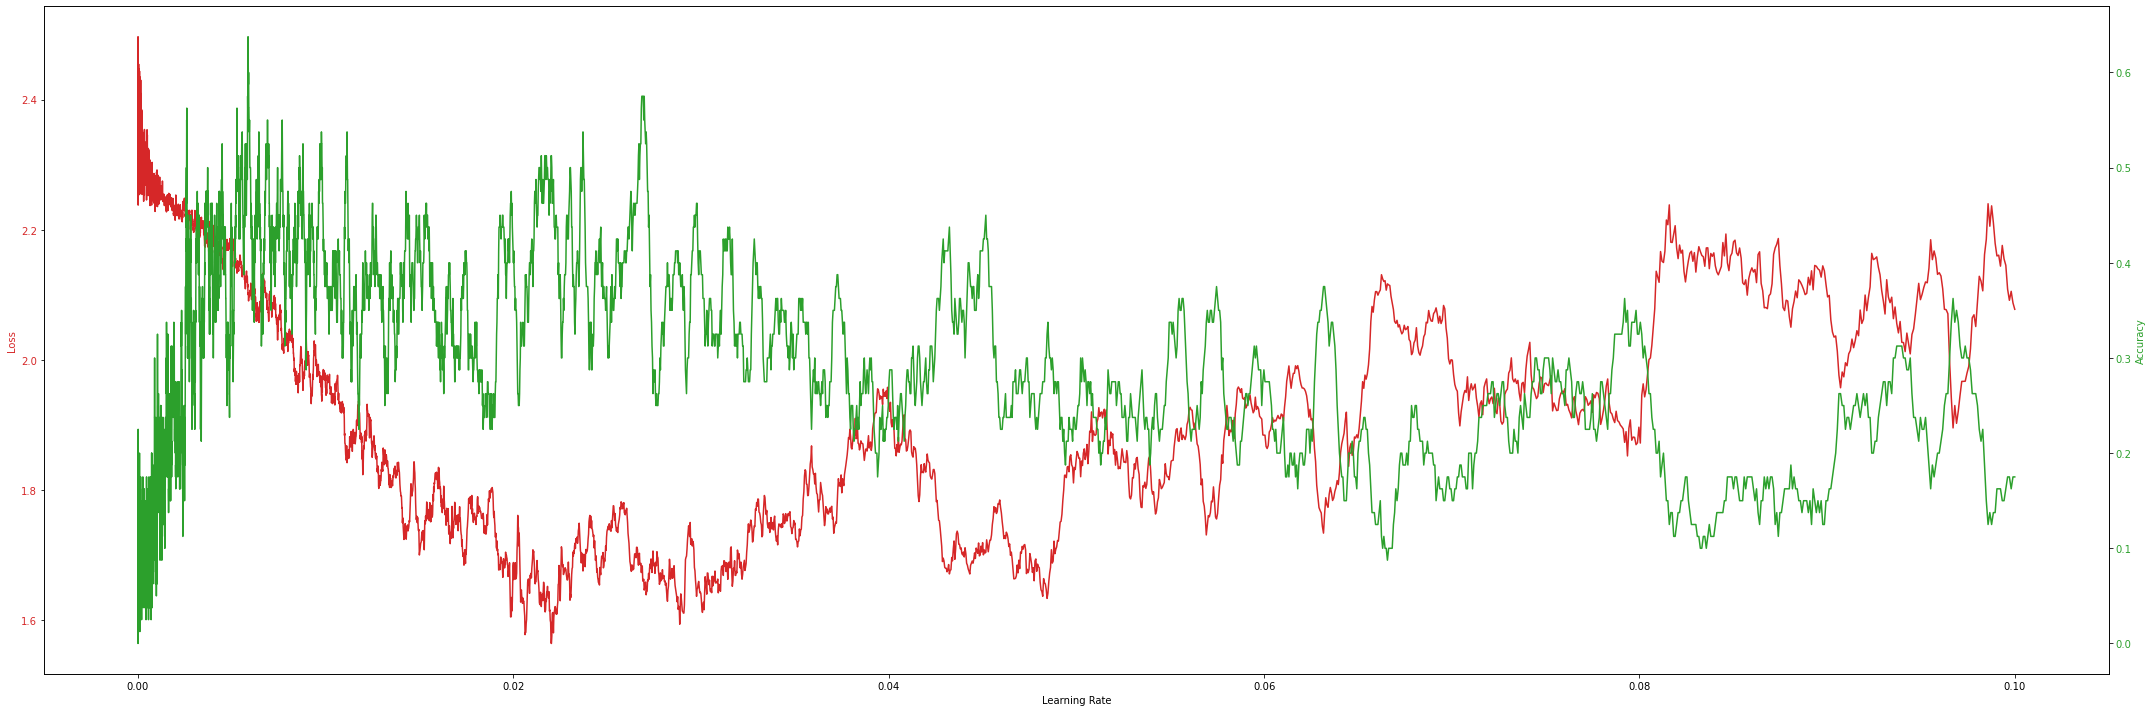

In [11]:
# подберите LR
net = VeryModel()
opt = optim.SGD(net.parameters(), lr=1e-3)
find_lr(net, opt, train_loader)

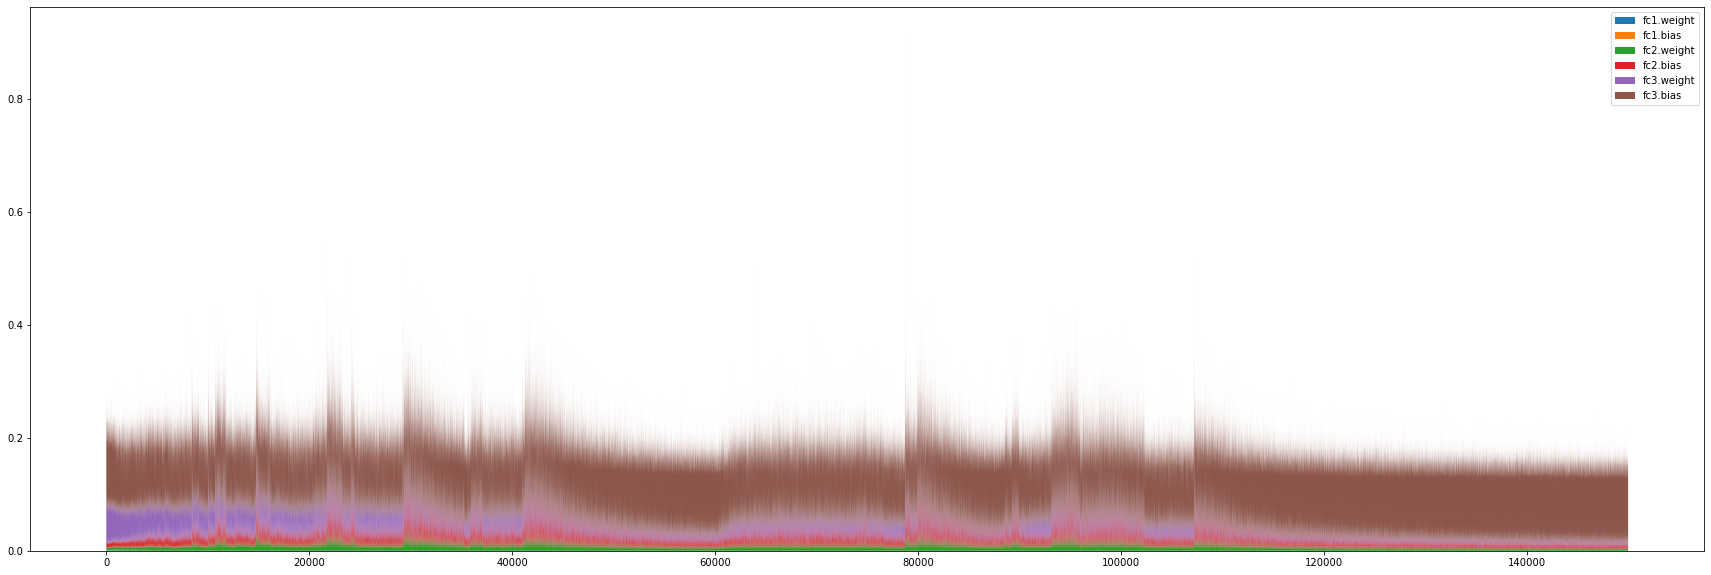

VeryModel(
  (fc1): Linear(in_features=784, out_features=40, bias=True)
  (fs1s): Sigmoid()
  (fc2): Linear(in_features=40, out_features=40, bias=True)
  (fc2s): Sigmoid()
  (fc3): Linear(in_features=40, out_features=10, bias=True)
)

In [33]:
net = VeryModel()
opt = optim.SGD(net.parameters(), lr=2e-2)
train_model(net, opt, train_loader, val_loader)

## Эксперимент с затухающими градиентами

Сделайте функцию, собирающую нормы градиентов по слоям.
Функция должна работать с GPU и CPU-моделями!

Ключи в словаре с нормами сделайте по именам слоев (используйте `model.named_parameters()` из предыдущей тетрадки).

In [11]:
def get_grad_norms(model):
    norms_dict = {}
    for name, param in model.named_parameters():
        norms_dict[name] = param.grad.abs().mean().detach().item()
    return norms_dict

# код для проверки корректности
model = nn.Sequential(
    nn.Linear(7, 11),
    nn.Sigmoid(),
    nn.Linear(11, 10),
)

x = torch.ones(13, 7)
loss = model(x).mean()
loss.backward()

assert get_grad_norms(model).keys() == {"0.weight", "0.bias", "2.weight", "2.bias"}

if torch.cuda.is_available():
    device = "cuda"
    model.to(device)
    x = x.to(device)
    loss = model(x).mean()
    loss.backward()
    assert get_grad_norms(model).keys() == {"0.weight", "0.bias", "2.weight", "2.bias"}
    print("All is fine")
else:
    print("GPU unchecked")

GPU unchecked


### Глубокая сеть

Сделайте глубокую сеть из полносвязных слоев и нелинейностей.
8 FC-слоев с нелинейностями между ними, постройте нормы градиентов по слоям от номера шага.
Размеры промежуточных тензоров возьмите 20 или 40 каналов.

Добавьте в функцию `train_model` вывод норм градиентов.

Ожидаемая картинка выглядит примерно так: <img src="./img/sad_network.png/">

In [12]:
import random

class VeryModelDeep(nn.Module):
    def __init__(self, in_channels=784):
        super().__init__()
        hidden_sizes = [20, 40]
        # construct weights for layers
        self.lin1 = nn.Linear(in_channels, random.choice(hidden_sizes))
        self.sig1 = nn.Sigmoid()
        self.lin2 = nn.Linear(self.lin1.out_features, random.choice(hidden_sizes))
        self.sig2 = nn.Sigmoid()
        self.lin3 = nn.Linear(self.lin2.out_features, random.choice(hidden_sizes))
        self.sig3 = nn.Sigmoid()
        self.lin4 = nn.Linear(self.lin3.out_features, random.choice(hidden_sizes))
        self.sig4 = nn.Sigmoid()
        self.lin5 = nn.Linear(self.lin4.out_features, random.choice(hidden_sizes))
        self.sig5 = nn.Sigmoid()
        self.lin6 = nn.Linear(self.lin5.out_features, random.choice(hidden_sizes))
        self.sig6 = nn.Sigmoid()
        self.lin7 = nn.Linear(self.lin6.out_features, random.choice(hidden_sizes))
        self.sig7 = nn.Sigmoid()
        self.lin8 = nn.Linear(self.lin7.out_features, 10)
    
    def forward(self, x):
        x = self.lin1(x)
        x = self.sig1(x)
        x = self.lin2(x)
        x = self.sig2(x)
        x = self.lin3(x)
        x = self.sig3(x)
        x = self.lin4(x)
        x = self.sig4(x)
        x = self.lin5(x)
        x = self.sig5(x)
        x = self.lin6(x)
        x = self.sig6(x)
        x = self.lin7(x)
        x = self.sig7(x)
        x = self.lin8(x)
        return nn.functional.log_softmax(x, dim=-1)
    
    def compute_all(self, batch):  # удобно сделать функцию, в которой вычисляется лосс по пришедшему батчу
        loss_function = torch.nn.CrossEntropyLoss()
        logits = self.forward(batch['sample'])
        loss = loss_function(logits, batch['label'])
        metrics = dict()
        metrics['acc'] = np.mean(np.argmax(logits.detach().numpy(), axis=-1) == batch['label'].detach().numpy())
        metrics['loss'] = loss.detach().numpy().item()
        return loss, metrics

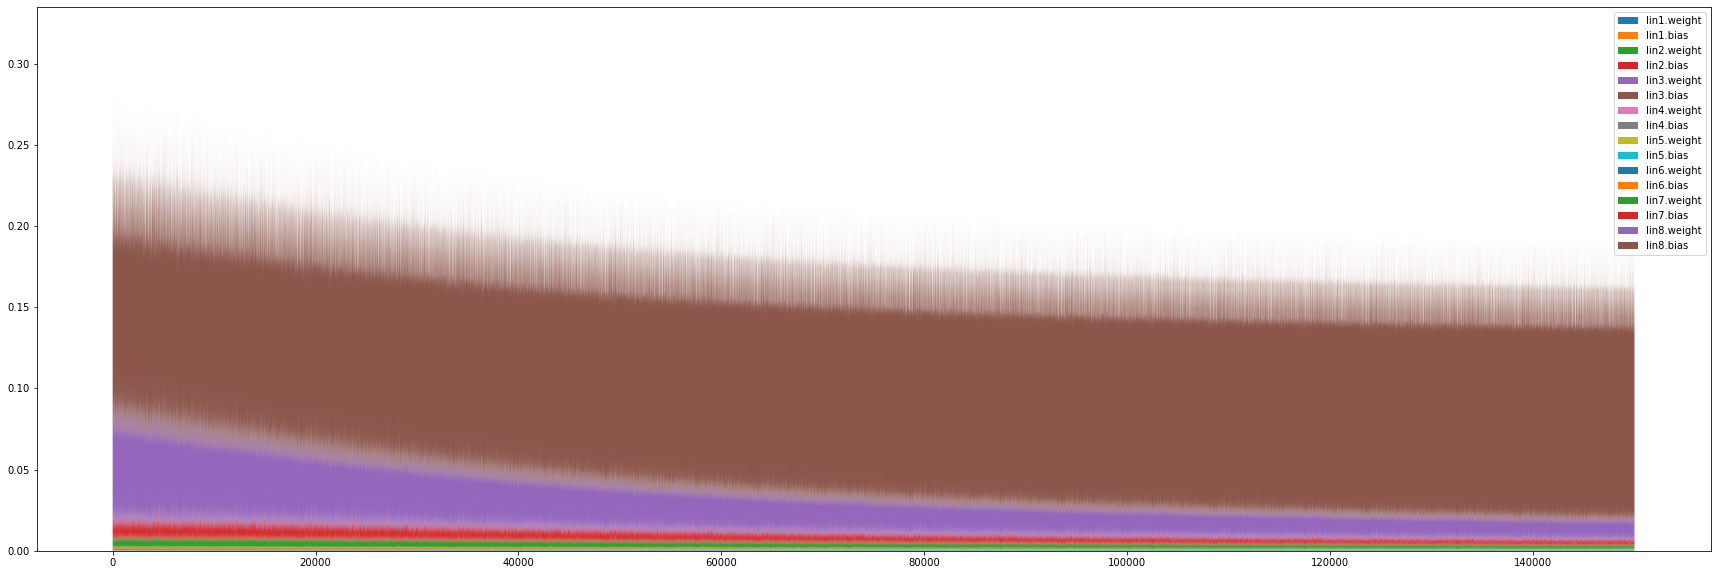

VeryModelDeep(
  (lin1): Linear(in_features=784, out_features=40, bias=True)
  (sig1): Sigmoid()
  (lin2): Linear(in_features=40, out_features=20, bias=True)
  (sig2): Sigmoid()
  (lin3): Linear(in_features=20, out_features=20, bias=True)
  (sig3): Sigmoid()
  (lin4): Linear(in_features=20, out_features=20, bias=True)
  (sig4): Sigmoid()
  (lin5): Linear(in_features=20, out_features=40, bias=True)
  (sig5): Sigmoid()
  (lin6): Linear(in_features=40, out_features=20, bias=True)
  (sig6): Sigmoid()
  (lin7): Linear(in_features=20, out_features=20, bias=True)
  (sig7): Sigmoid()
  (lin8): Linear(in_features=20, out_features=10, bias=True)
)

In [13]:
net = VeryModelDeep() # changed to a new class to keep initial schema as reference
opt = optim.SGD(net.parameters(), lr=2e-2)
train_model(net, opt, train_loader, val_loader)

Есть по крайней мере несколько способов, которые могут помочь заставить эту сеть учиться (без изменения глубины):
- использовать другую функцию активации
- выбрать LR для каждого слоя
- собрать сеть из других блоков

Вы можете попробовать первый или второй (или какой-нибудь свой) вариант, но сопроводите, пожалуйста, код письменными рассуждениями.

### Residual Blocks

Если сеть собирать из блоков вида
```
y = x + F(x)
```
где F(x) -- это FC-слой + нелинейность, градиенты будут протекать гораздо лучше (поскольку есть путь без нелинейностей).

<img src="./img/resblock.png">

Реализуйте каким-либо образом ResNet с 8 нелинейностями с тем же количеством каналов.

Постройте картинку с градиентами по слоям для каждого шага.

In [13]:
class ResModel(nn.Module):
    def __init__(self, in_channels=784):
        super().__init__()
        # construct weights for layers
        self.lin1 = nn.Linear(in_channels, 20)
        self.sig1 = nn.Sigmoid()
        self.lin2 = nn.Linear(self.lin1.out_features, 20)
        self.sig2 = nn.Sigmoid()
        self.shortcut_1_3 = nn.Sequential()
        self.lin3 = nn.Linear(self.lin2.out_features, 20)
        self.sig3 = nn.Sigmoid()
        self.shortcut_2_4 = nn.Sequential()
        self.lin4 = nn.Linear(self.lin3.out_features, 20)
        self.sig4 = nn.Sigmoid()
        self.shortcut_3_5 = nn.Sequential()
        self.lin5 = nn.Linear(self.lin4.out_features, 20)
        self.sig5 = nn.Sigmoid()
        self.shortcut_4_6 = nn.Sequential()
        self.lin6 = nn.Linear(self.lin5.out_features, 20)
        self.sig6 = nn.Sigmoid()
        self.shortcut_5_7 = nn.Sequential()
        self.lin7 = nn.Linear(self.lin6.out_features, 20)
        self.sig7 = nn.Sigmoid()
        self.shortcut_6_8 = nn.Sequential()
        self.lin8 = nn.Linear(self.lin7.out_features, 10)
    
    def forward(self, x):
        x = self.lin1(x)
        x = self.sig1(x)
        residue = x
        x = self.lin2(x)
        x = self.sig2(x)
        x = x + self.shortcut_1_3(residue)
        residue = x
        x = self.lin3(x)
        x = self.sig3(x)
        x = x + self.shortcut_2_4(residue)
        residue = x
        x = self.lin4(x)
        x = self.sig4(x)
        x = x + self.shortcut_3_5(residue)
        residue = x
        x = self.lin5(x)
        x = self.sig5(x)
        x = x + self.shortcut_4_6(residue)
        residue = x
        x = self.lin6(x)
        x = self.sig6(x)
        x = x + self.shortcut_5_7(residue)
        residue = x
        x = self.lin7(x)
        x = self.sig7(x)
        x = x + self.shortcut_6_8(residue)
        x = self.lin8(x)
        return nn.functional.log_softmax(x, dim=-1)
    
    def compute_all(self, batch):  # удобно сделать функцию, в которой вычисляется лосс по пришедшему батчу
        loss_function = torch.nn.CrossEntropyLoss()
        logits = self.forward(batch['sample'])
        loss = loss_function(logits, batch['label'])
        metrics = dict()
        metrics['acc'] = np.mean(np.argmax(logits.detach().numpy(), axis=-1) == batch['label'].detach().numpy())
        metrics['loss'] = loss.detach().numpy().item()
        return loss, metrics

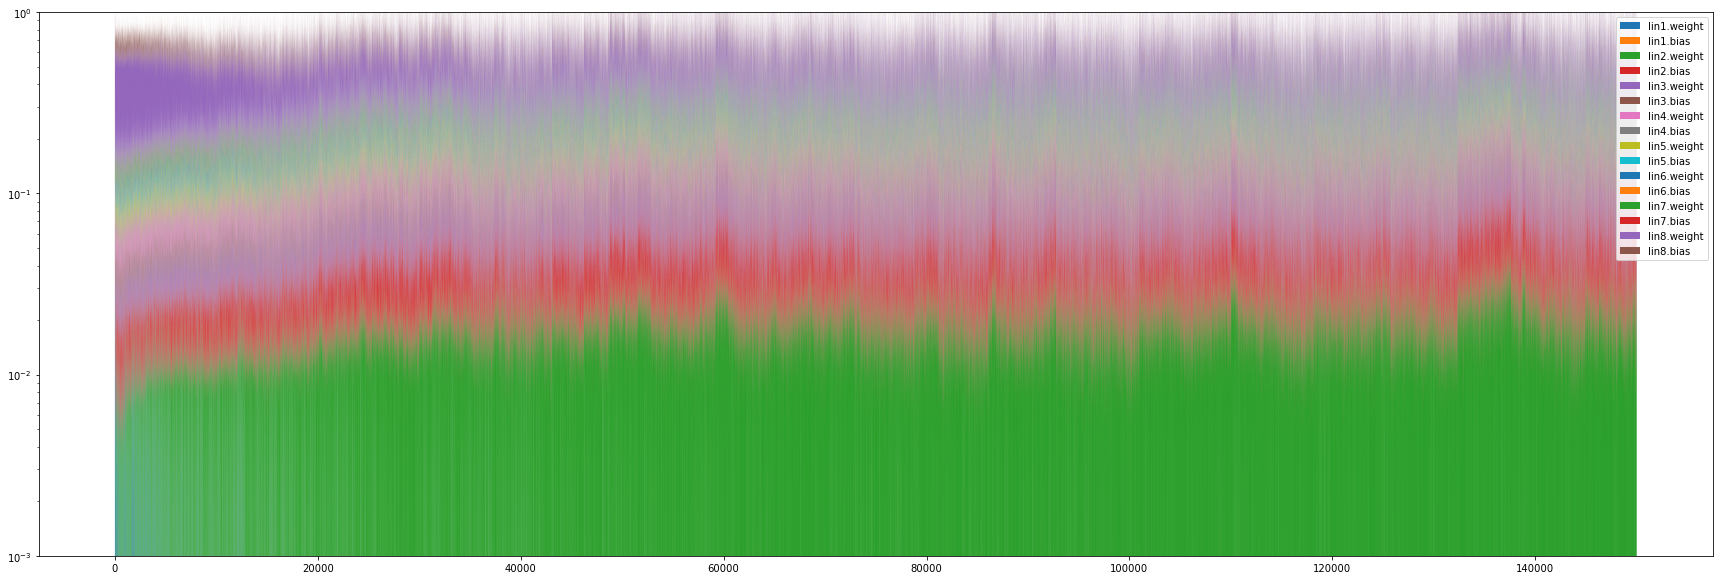

ResModel(
  (lin1): Linear(in_features=784, out_features=20, bias=True)
  (sig1): Sigmoid()
  (lin2): Linear(in_features=20, out_features=20, bias=True)
  (sig2): Sigmoid()
  (shortcut_1_3): Sequential()
  (lin3): Linear(in_features=20, out_features=20, bias=True)
  (sig3): Sigmoid()
  (shortcut_2_4): Sequential()
  (lin4): Linear(in_features=20, out_features=20, bias=True)
  (sig4): Sigmoid()
  (shortcut_3_5): Sequential()
  (lin5): Linear(in_features=20, out_features=20, bias=True)
  (sig5): Sigmoid()
  (shortcut_4_6): Sequential()
  (lin6): Linear(in_features=20, out_features=20, bias=True)
  (sig6): Sigmoid()
  (shortcut_5_7): Sequential()
  (lin7): Linear(in_features=20, out_features=20, bias=True)
  (sig7): Sigmoid()
  (shortcut_6_8): Sequential()
  (lin8): Linear(in_features=20, out_features=10, bias=True)
)

In [20]:
net = ResModel()
opt = optim.SGD(net.parameters(), lr=1e-3)
train_model(net, opt, train_loader, val_loader)

#### Картинки из TensorBoard:
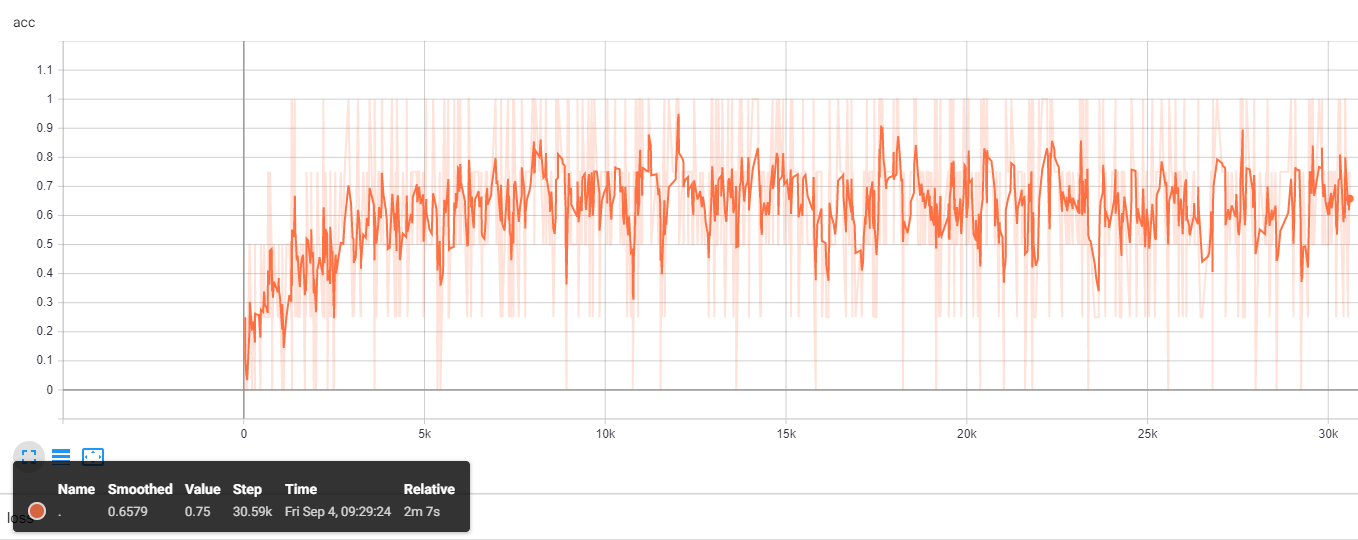
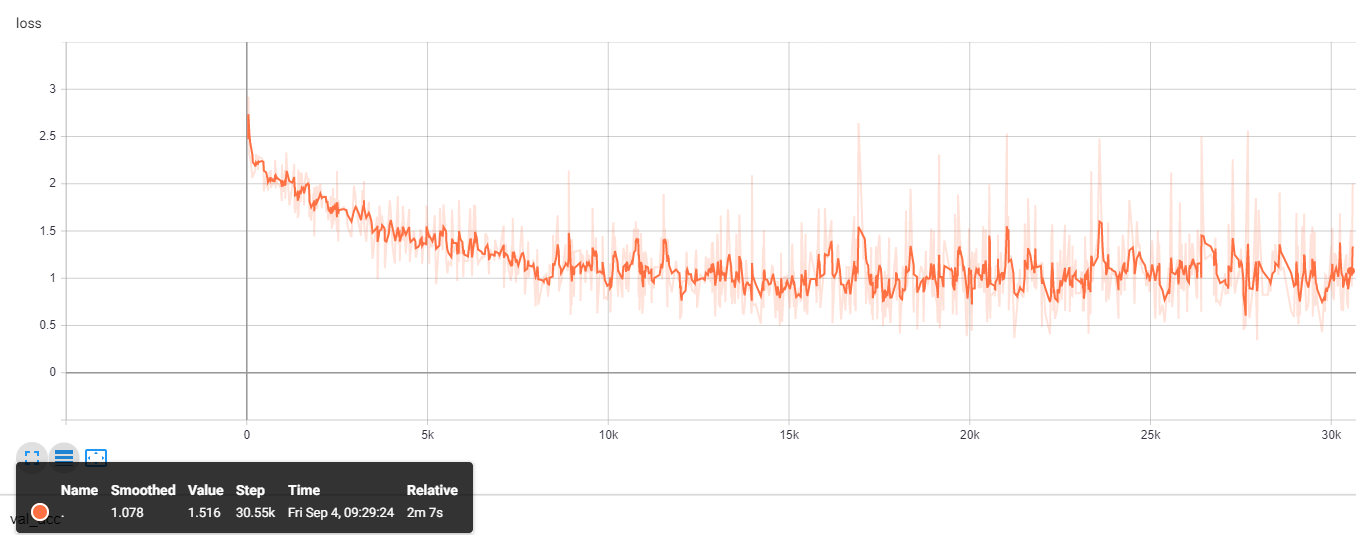
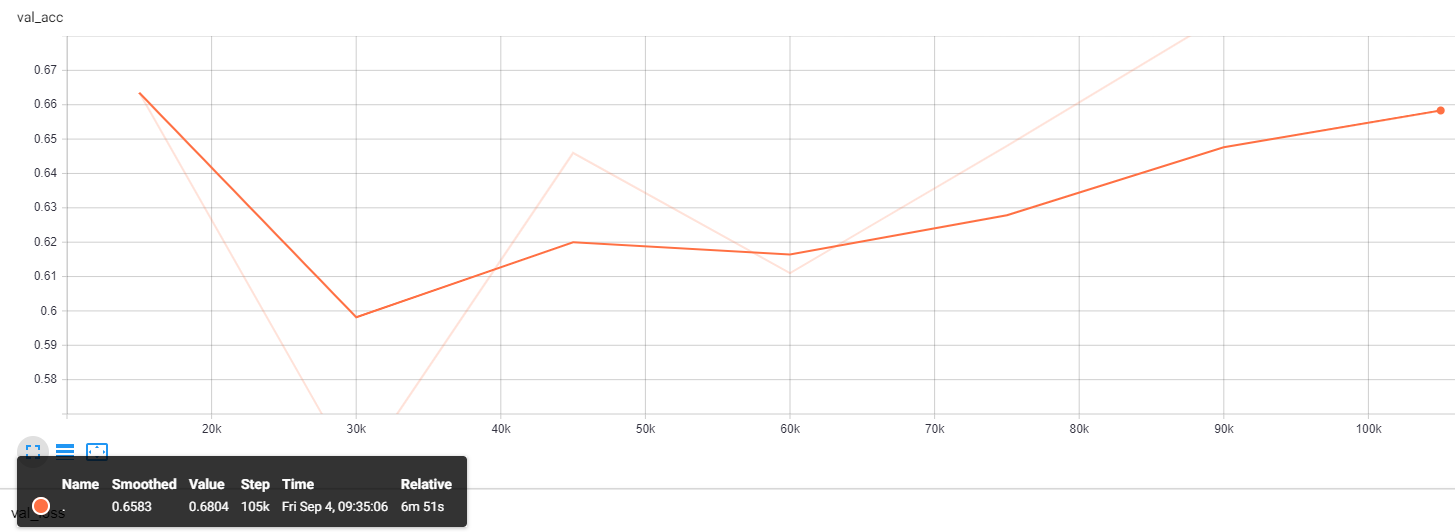
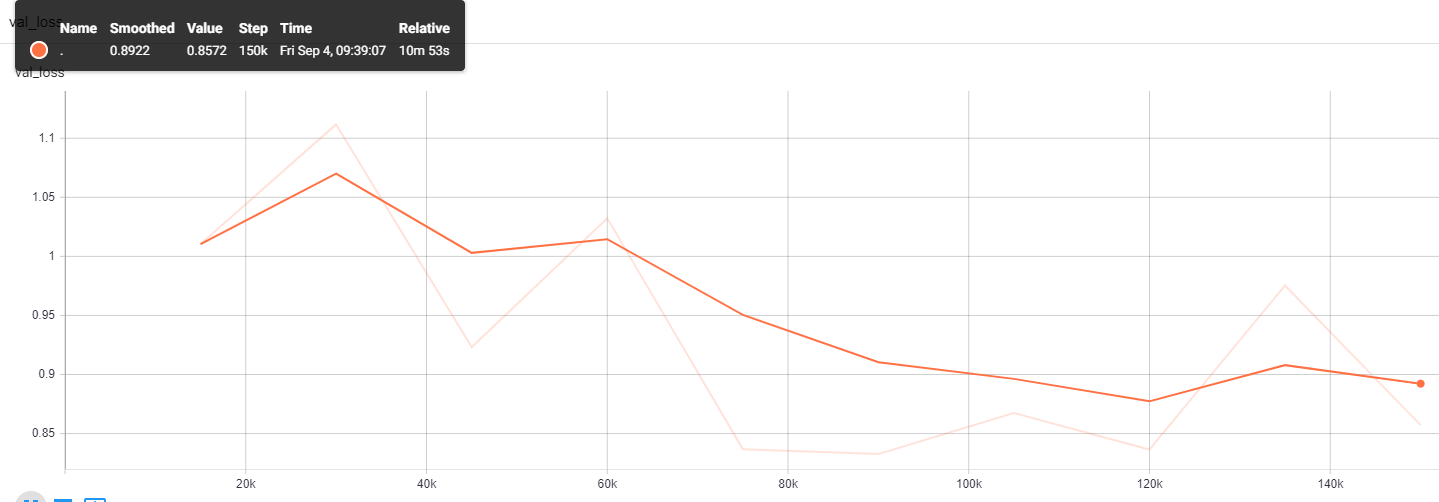

### Вариант№2, с билдинг блоками (и возможностью разных размерностей между слоями - в 1ом варианте были все одинаковы)

In [28]:
class BasicBlock(nn.Module):
    '''
    Building block consisting of 2 layers of Linear + Sigmoid, and additional link from input to output
    '''
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.out_features = out_channels
#         hidden_sizes = [20, 40]
        self.lin1 = nn.Linear(in_channels, 40)
        self.sig1 = nn.Sigmoid()
        self.lin2 = nn.Linear(self.lin1.out_features, out_channels)
        self.sig2 = nn.Sigmoid()
        
        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            print('Warning: nonlinear shortcut')
            self.shortcut = nn.Sequential(
                nn.Linear(in_channels, out_channels),
                nn.Sigmoid()
            )
    
    def forward(self, x):
        temp = self.lin1(x)
        temp = self.sig1(temp)
        temp = self.lin2(temp)
        temp = self.sig2(temp)
        out = temp + self.shortcut(x)
        return out


class ResModelWithBlocks(nn.Module):
    '''
    ResNet example with building blocks
    '''
    def __init__(self, in_channels=784):
        super().__init__()
#         hidden_sizes = [20, 40]
#         убрал рандомность - с ней градиенты снова затухали
#         тест с моделью "20 каналов между слоями, 40 внутри - и прямой sequential shortcut"
        # input layer
        self.input_layer = nn.Linear(in_channels, 20)
        # 3 blocks of 2 Linear+Sigmoids each = 6 in total
        self.block_1 = BasicBlock(self.input_layer.out_features, 20)
        self.block_2 = BasicBlock(self.block_1.out_features, 20)
        self.block_3 = BasicBlock(self.block_2.out_features, 20)
        # output layer
        self.output_layer = nn.Linear(self.block_3.out_features, 10)
    
    def forward(self, x):
        temp = self.input_layer(x)
        temp = self.block_1(temp)
        temp = self.block_2(temp)
        temp = self.block_3(temp)
        temp = self.output_layer(temp)
        return nn.functional.log_softmax(temp, dim=-1)
    
    def compute_all(self, batch):  # лосс по пришедшему батчу
        loss_function = torch.nn.CrossEntropyLoss()
        logits = self.forward(batch['sample'])
        loss = loss_function(logits, batch['label'])
        metrics = dict()
        metrics['acc'] = np.mean(np.argmax(logits.detach().numpy(), axis=-1) == batch['label'].detach().numpy())
        metrics['loss'] = loss.detach().numpy().item()
        return loss, metrics

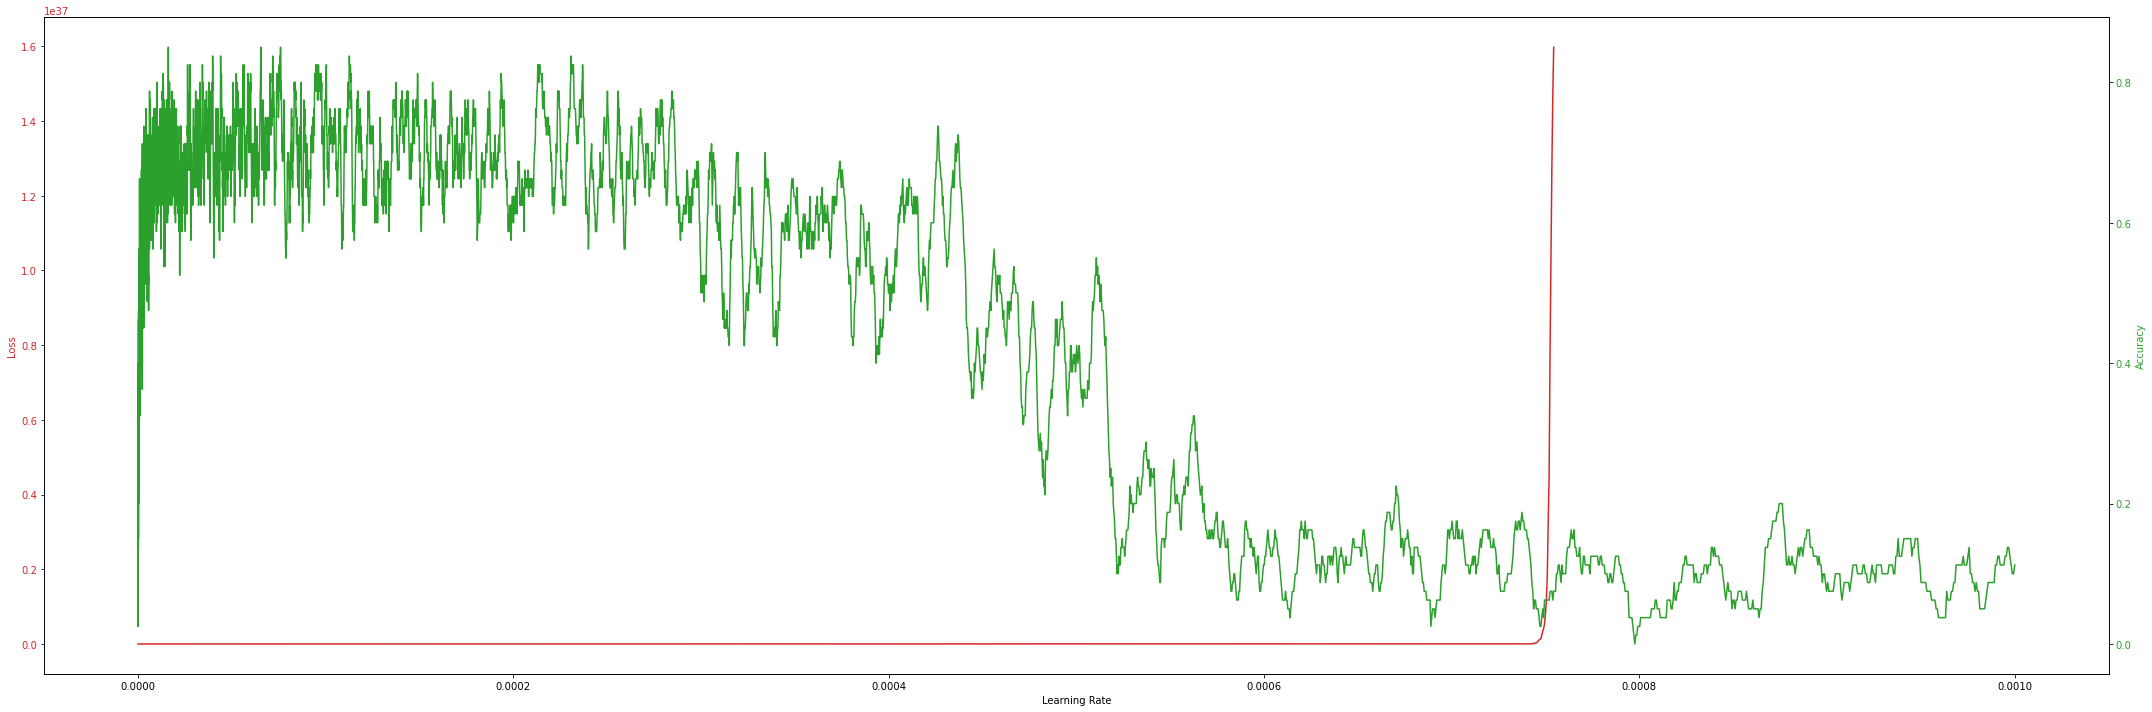

In [32]:
# подбор LR
net = ResModelWithBlocks()
opt = optim.SGD(net.parameters(), lr=1e-3)
find_lr(net, opt, train_loader, lower=6e-8, upper=1e-3)

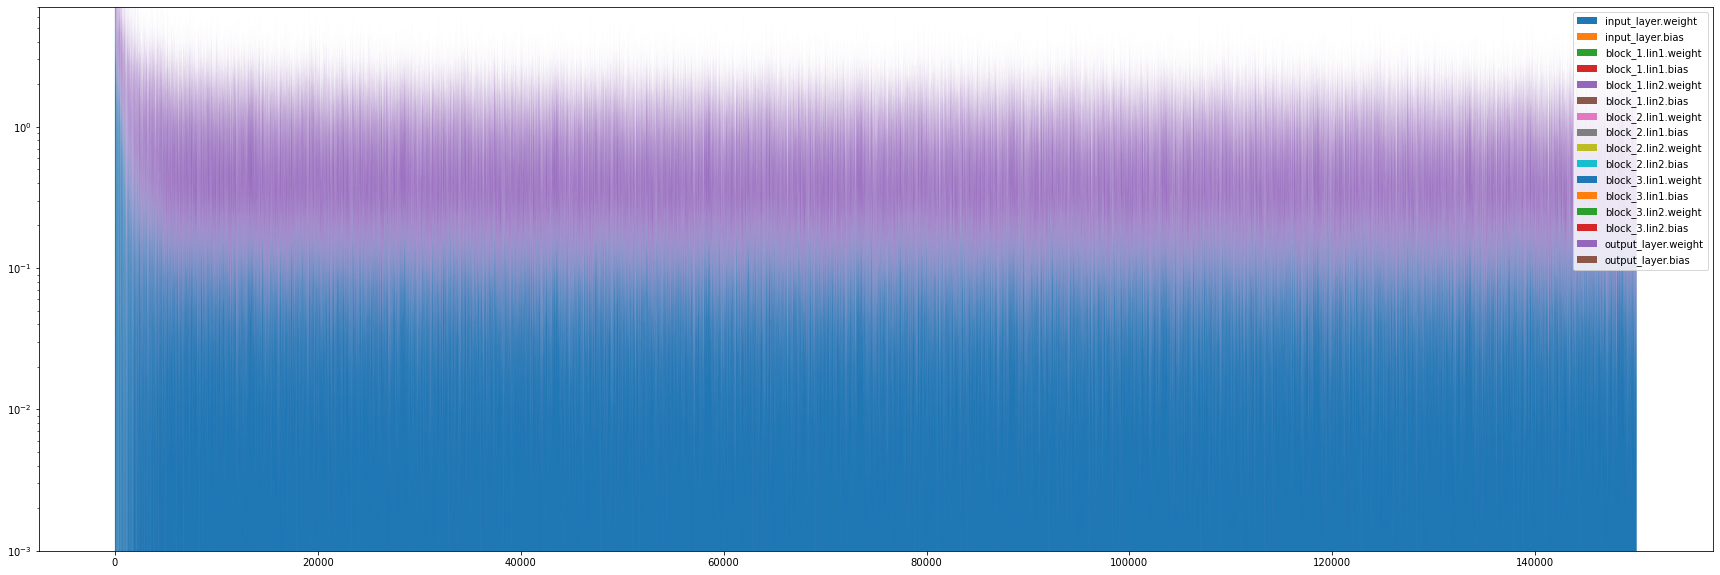

ResModelWithBlocks(
  (input_layer): Linear(in_features=784, out_features=20, bias=True)
  (block_1): BasicBlock(
    (lin1): Linear(in_features=20, out_features=40, bias=True)
    (sig1): Sigmoid()
    (lin2): Linear(in_features=40, out_features=20, bias=True)
    (sig2): Sigmoid()
    (shortcut): Sequential()
  )
  (block_2): BasicBlock(
    (lin1): Linear(in_features=20, out_features=40, bias=True)
    (sig1): Sigmoid()
    (lin2): Linear(in_features=40, out_features=20, bias=True)
    (sig2): Sigmoid()
    (shortcut): Sequential()
  )
  (block_3): BasicBlock(
    (lin1): Linear(in_features=20, out_features=40, bias=True)
    (sig1): Sigmoid()
    (lin2): Linear(in_features=40, out_features=20, bias=True)
    (sig2): Sigmoid()
    (shortcut): Sequential()
  )
  (output_layer): Linear(in_features=20, out_features=10, bias=True)
)

In [38]:
# обучение модели
net = ResModelWithBlocks()
opt = optim.SGD(net.parameters(), lr=1e-4)
train_model(net, opt, train_loader, val_loader, writerpath="./model_training_log/040911_blocks_try4")

#### Градиенты снова выродились во входной и выходной слой, НО! Accuracy 81% вместо 66%, не это ли важнее?


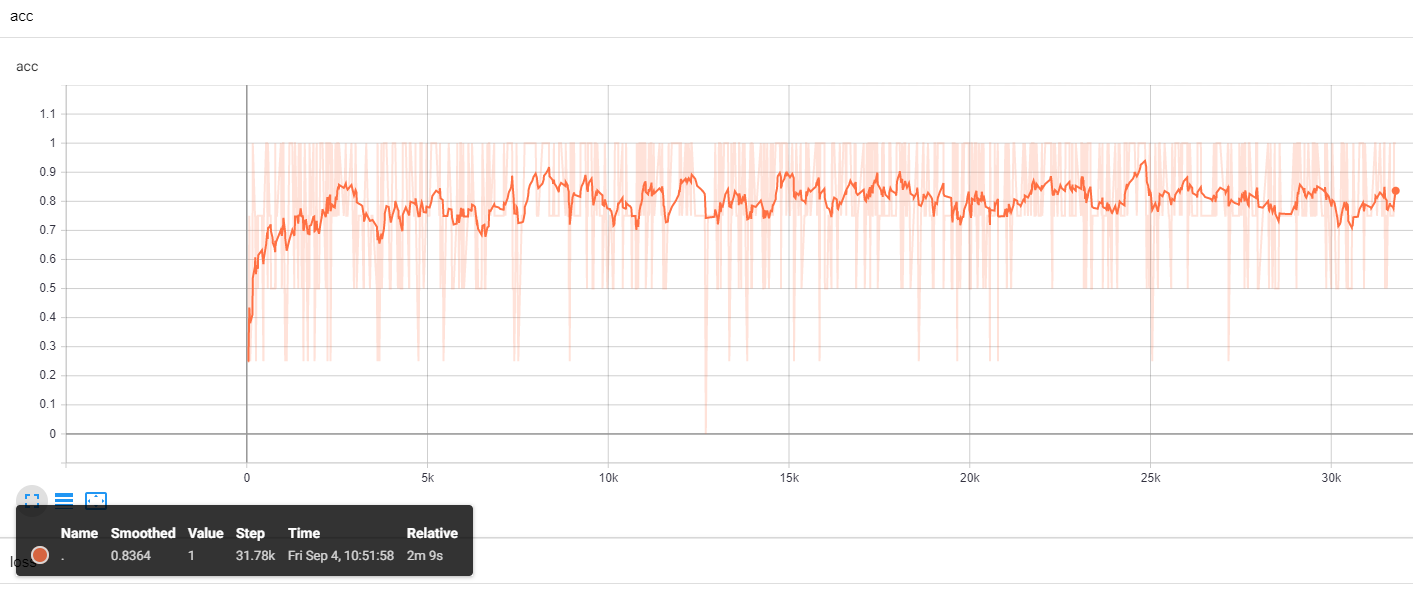
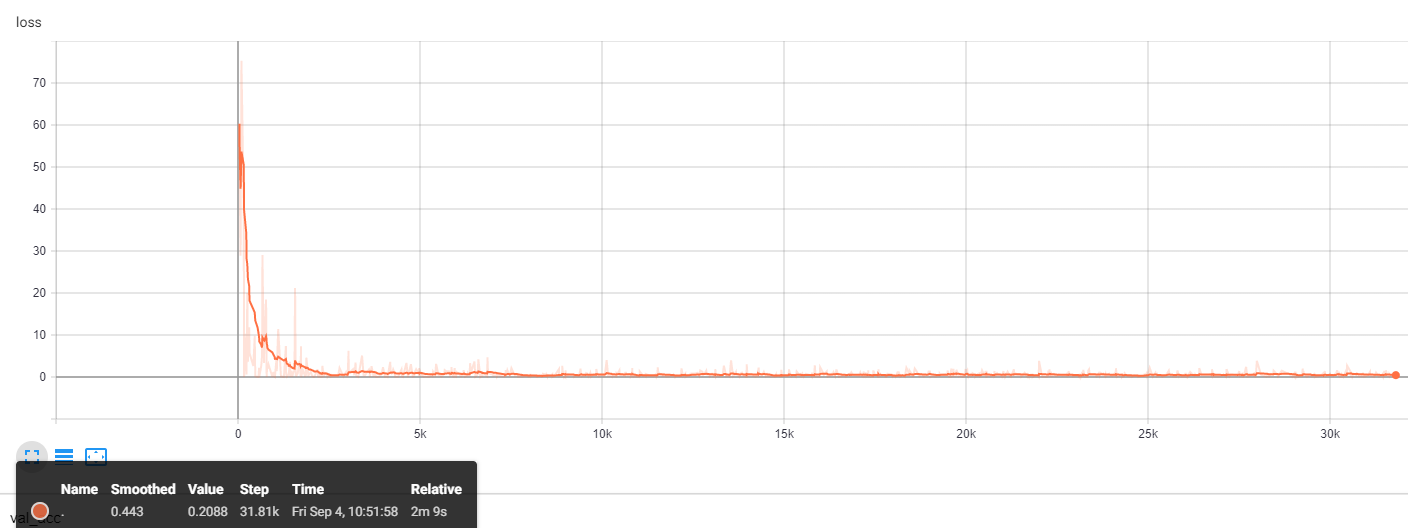
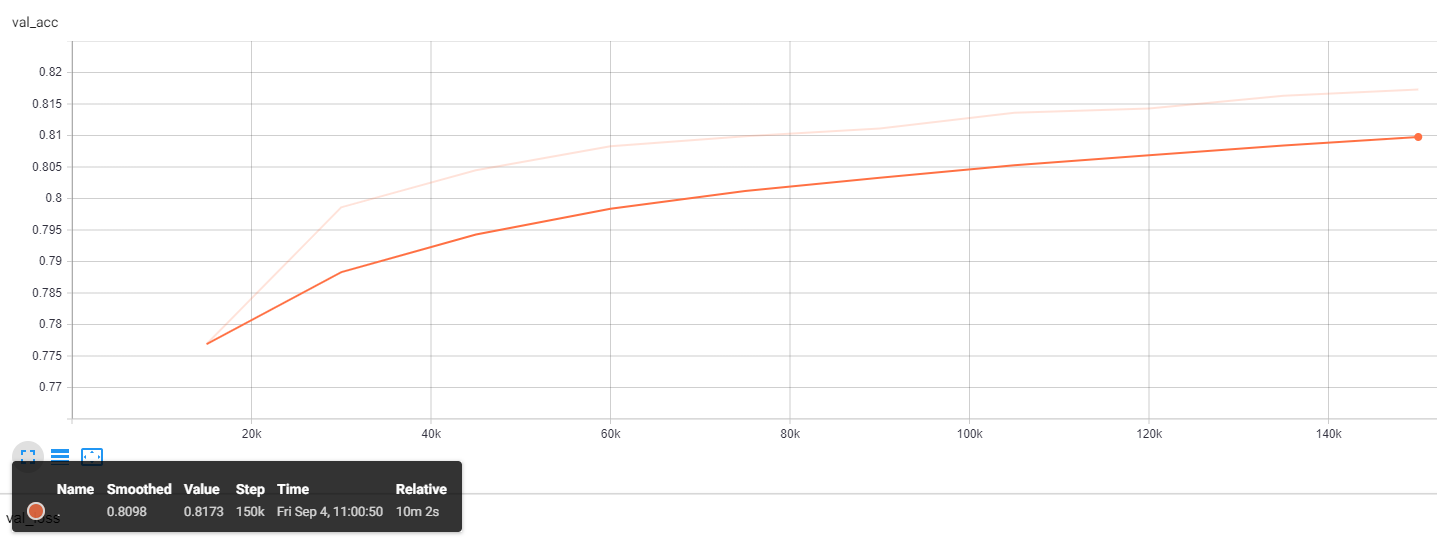
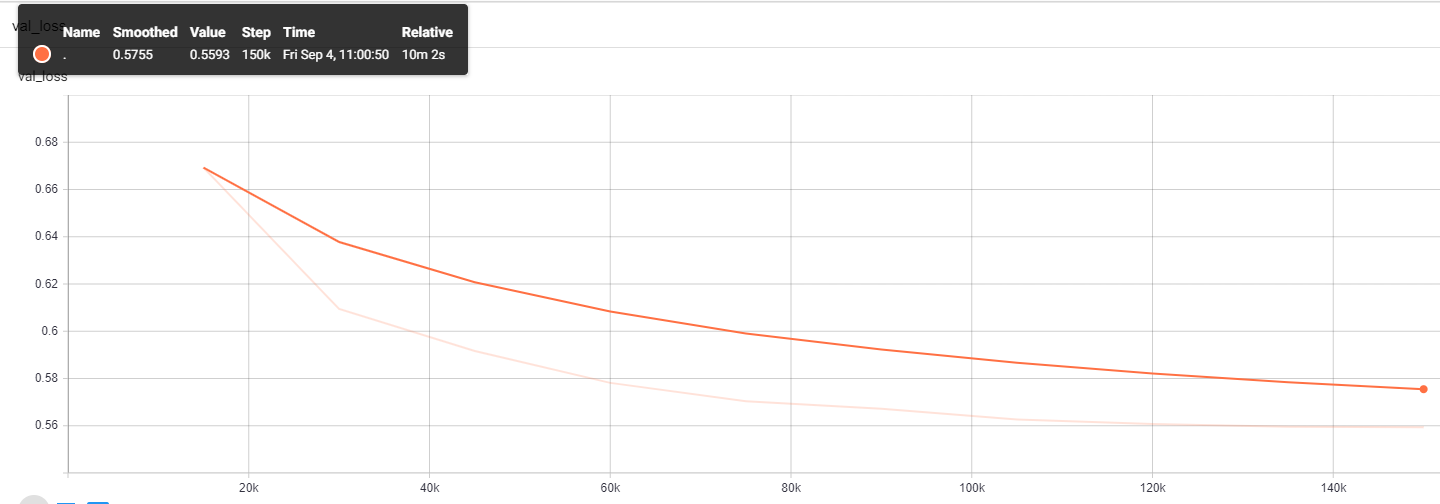